In [59]:
import scipy,corner,emcee,nestle
import pandas
import scipy.optimize
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np

In [60]:
example_data_1D = pandas.read_csv('1D_intro_examples.dat',sep=' ',header=0)
print(example_data_1D.head())

          x          y      error
0  0.585921  13.648840  10.321681
1  0.664152   7.321433  12.307353
2  0.666299   8.691450  11.459853
3  0.717126  -7.759708  14.261307
4  0.828552   8.019604  11.597092


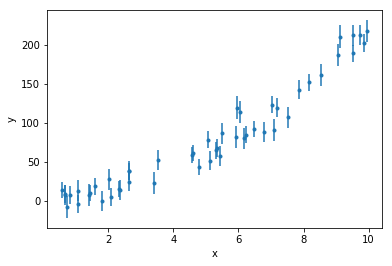

In [61]:
plt.errorbar(example_data_1D['x'],example_data_1D['y'],yerr=example_data_1D['error'],fmt='.')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [62]:
#True values are:
a_true=2
b_true=1.3
c_true=6
def my_model(x,a,b,c):
    return(a*x**2+b*x+c)

**Data Fitting: Chi-Square Minimization**
===============================

Chi-square fit: 1.9714519942696358 1.644806132395904 4.826698787458533
True: 2 1.3 6


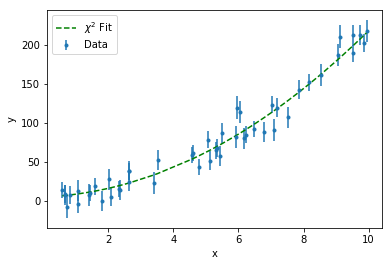

In [63]:
#Let's try and fit the data with a simple chi-square minimization
def chisq_likelihood(theta, args):
    #This function accepts a set of model parameters a,b and c
        #and returns a chi square value, comparing with the 
        #times,observations,errors, and model provided in args
    x, y, yerr,mod=args
    a,b,c = theta
    model = mod(x,a,b,c)
    inv_sigma2 = 1./yerr**2
    return 0.5*(np.sum((y-model)**2*inv_sigma2 ))

result = scipy.optimize.minimize(chisq_likelihood, [1,1,1], 
                                 args=[example_data_1D['x'],example_data_1D['y'],example_data_1D['error'],my_model])
a_ml, b_ml,c_ml = result["x"]
plt.errorbar(example_data_1D['x'],example_data_1D['y'],yerr=example_data_1D['error'],fmt='.',label='Data')
plt.plot(example_data_1D['x'],my_model(example_data_1D['x'],a_ml,b_ml,c_ml),'g--',label='$\chi^2$ Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
print('Chi-square fit:',a_ml, b_ml,c_ml)
print('True:',a_true,b_true,c_true)
plt.show()

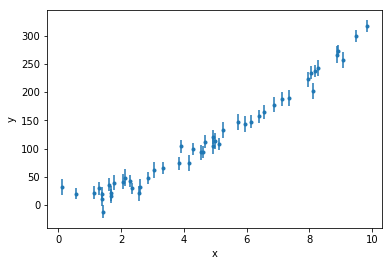

In [64]:
#Now let's look at a drawback of the chi-square minimization.
#    What if there are parameter degeneracies in the model,
#    or some sort of local minimum in the chi-square?


#This model has one of the parameters squared, so either -b or b will give
#    the same result
def my_bad_model(x,a,b,c):
    return(a*x**2+b**2*x+c)
a_true_bad=2
b_true_bad=-3.3
c_true_bad=6
#Read in some data generated with this model. The parameters used were v=50,g=-10
my_bad_data_1D=pandas.read_csv("1D_intro_examples_bad.dat",header=0,sep=' ')
plt.errorbar(my_bad_data_1D['x'],my_bad_data_1D['y'],yerr=my_bad_data_1D['error'],fmt='.')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


Chi-square fit: 2.1072518697498577 3.2891181201455897 3.917405806079259
True: 2 -3.3 6


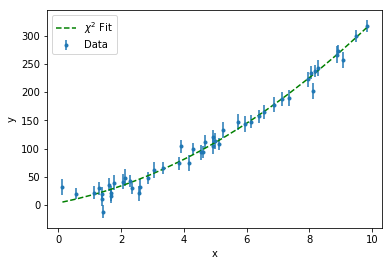

In [65]:
#Try and fit the data with this model, using new bounds
result_bad = scipy.optimize.minimize(chisq_likelihood, [1,1,1],bounds=[(0,10),(0,10),(0,10)], 
                                 args=[my_bad_data_1D['x'],my_bad_data_1D['y'],my_bad_data_1D['error'],my_bad_model])
a_ml, b_ml,c_ml = result_bad["x"]
plt.errorbar(my_bad_data_1D['x'],my_bad_data_1D['y'],yerr=my_bad_data_1D['error'],fmt='.',label='Data')
plt.plot(my_bad_data_1D['x'],my_bad_model(my_bad_data_1D['x'],a_ml,b_ml,c_ml),'g--',label='$\chi^2$ Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
print('Chi-square fit:',a_ml, b_ml,c_ml)
print('True:',a_true_bad,b_true_bad,c_true_bad)
plt.show()
#However, in this (very contrived) case, the true value of b is -3.3

# Data Fitting: MCMC

In [66]:
# We can combine a likelihood function with a prior function
def lnprob(theta, x, y, yerr,mod):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp - chisq_likelihood(theta, [x, y, yerr,mod])

def lnprior(theta):
    a, b,c = theta
    if 0 < a < 5. and -5 < b < 5 and 0 < c < 10:
        return 0.0
    return -np.inf

ndim, nwalkers = 3, 100
pos = [result["x"] + .1*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(example_data_1D['x'], example_data_1D['y'], example_data_1D['error'],my_model))
sampler.run_mcmc(pos, 500)
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))


MCMC: a= 1.9778332153874942 b= 1.5707547602114418 c= 5.0854910545547085
True: a= 2 b= 1.3 c= 6


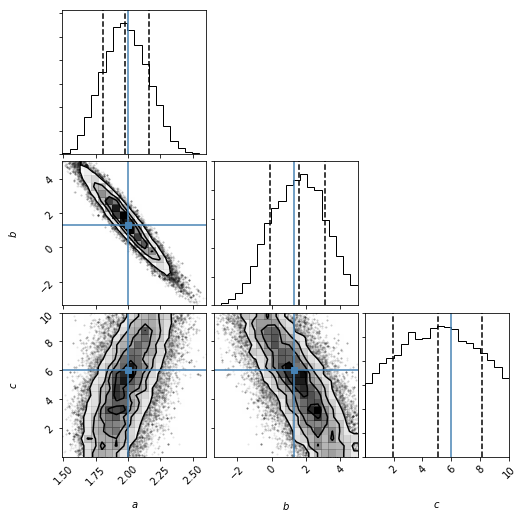

In [67]:
a_mcmc, b_mcmc,c_mcmc = np.percentile(samples, 50,axis=0)
print('MCMC:','a=',a_mcmc,'b=',b_mcmc,'c=',c_mcmc)
print('True:','a=',a_true,'b=', b_true,'c=',c_true)
fig = corner.corner(samples, labels=["$a$", "$b$","$c$"],quantiles=(0.16,0.50,0.84),
                      truths=[a_true, b_true,c_true])
plt.show()

In [ ]:
ndim, nwalkers = 3, 100
pos = [result_bad["x"] - 2*np.abs(np.random.randn(ndim)) for i in range(nwalkers)]

sampler_bad = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(my_bad_data_1D['x'], my_bad_data_1D['y'], my_bad_data_1D['error'],my_bad_model))
sampler_bad.run_mcmc(pos, 500)
samples_bad = sampler_bad.chain[:, 50:, :].reshape((-1, ndim))

In [ ]:
a_mcmc, b_mcmc,c_mcmc = np.percentile(samples_bad, 50,axis=0)
print('MCMC:','a=',a_mcmc,'b=',b_mcmc,'c=',c_mcmc)
print('True:','a=',a_true_bad,'b=', b_true_bad,'c=',c_true_bad)
fig = corner.corner(samples_bad, labels=["$a$", "$b$","$c$"],
                      truths=[a_true_bad, b_true_bad,c_true_bad])
plt.show()

# Nested Sampling

In [57]:
# Define a likelihood function
def loglike(theta):
    args=(example_data_1D['x'],example_data_1D['y'],example_data_1D['error'],my_model)
    chisq = chisq_likelihood(theta,args)
    return -.5*chisq


def prior_transform(x):
    return np.array([5., 10., 10.]) * x + np.array([0., -5., 0.])

# Run nested sampling.
result_nest = nestle.sample(loglike, prior_transform, 3,npoints=1000)

NameError: name 'example_data_1D' is not defined

In [58]:
a_nest, b_nest,c_nest = np.percentile(result_nest.samples, 50,axis=0)
print('Nested:','a=',a_nest,'b=',b_nest,'c=',c_nest)
print('True:','a=',a_true,'b=', b_true,'c=',c_true)
fig = corner.corner(result_nest.samples, labels=["$a$", "$b$","$c$"],quantiles=(0.16,0.50, 0.84),
                      weights=result_nest.weights,truths=[a_true, b_true,c_true])
plt.show()

NameError: name 'result_nest' is not defined

In [ ]:
def loglike(theta):
    args=(my_bad_data_1D['x'],my_bad_data_1D['y'],my_bad_data_1D['error'],my_bad_model)
    chisq = chisq_likelihood(theta,args)
    return -.5*chisq


def prior_transform(x):
    return np.array([5., 10., 10.]) * x + np.array([0., -5., 0.])

# Run nested sampling.
result_nest_bad = nestle.sample(loglike, prior_transform, 3,npoints=1000)

a_nest_bad, b_nest_bad,c_nest_bad = np.percentile(result_nest_bad.samples, 50,axis=0)


In [ ]:
print('Nested:','a=',a_nest_bad,'b=',b_nest_bad,'c=',c_nest_bad)
print('True:','a=',a_true_bad,'b=', b_true_bad,'c=',c_true_bad)
fig = corner.corner(result_nest_bad.samples, labels=["$a$", "$b$","$c$"],
                      weights=result_nest_bad.weights,truths=[a_true_bad, b_true_bad,c_true_bad])
plt.show()

# Likelihood with Assumed PDF 

In [85]:
true_energy_mean = 10
true_energy_std = 1
N_energies = 100

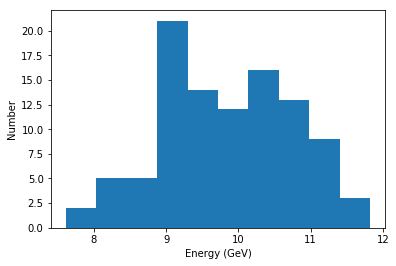

In [86]:
np.random.seed(67)
observed_energies=np.random.normal(loc=true_energy_mean,
                          scale=true_energy_std,
                          size=N_energies)
plt.hist(observed_energies)
plt.xlabel('Energy (GeV)')
plt.ylabel('Number')
plt.show()

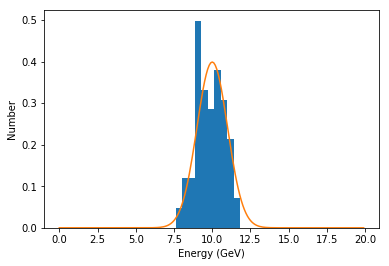

In [87]:
def my_energy_model(energy_mean,energy_std,possible_energy):
        return(scipy.stats.norm.pdf(possible_energy,energy_mean,energy_std))

possible_energies=np.arange(0,20,.1)
model_energies=my_energy_model(10,1,possible_energies)
plt.hist(observed_energies,density=True)
plt.plot(possible_energies,model_energies)
plt.xlabel('Energy (GeV)')
plt.ylabel('Number')
plt.show()

## What is the all data likelihood function for all the data?

In [99]:
def all_data_likelihood_function(model_parameters):
    model_mean,model_std = model_parameters
    likelihoods = my_energy_model(model_mean,model_std,observed_energies)
    #print(likelihoods)
    #likelihood = 1.
    #for data_point in observed_energies:
    #    single_datapoint_likelihood = my_energy_model(model_mean,model_std,data_point)
    #    likelihood *= single_datapoint_likelihood
    return(np.sum(np.log(likelihoods)))

In [100]:
all_data_likelihood = all_data_likelihood_function( ( 10, 1) )
#plt.scatter(observed_energies,all_data_likelihood)
print(all_data_likelihood)

-135.4253366186244


In [109]:
def prior_transform(x):
    return np.array([20., 5.]) * x + np.array([0., 0.]) 

# Run nested sampling.
energy_result_nest = nestle.sample(all_data_likelihood_function, 
                            prior_transform, 2,npoints=1000)

/Users/jpierel/anaconda3/envs/sntd_test3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Nested: a= 9.833013818885602 b= 1.1422007094767386
True: a= 10 b= 1


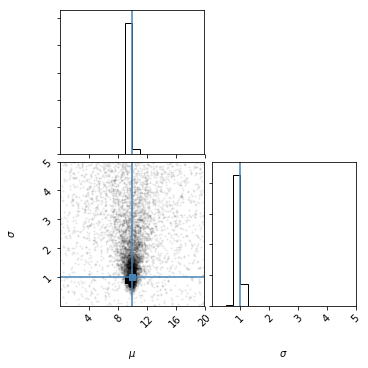

In [110]:
mean_nest, std_nest = np.percentile(energy_result_nest.samples, 50,axis=0)
print('Nested:','a=',mean_nest,'b=',std_nest)
print('True:','a=',true_energy_mean,'b=', true_energy_std)
fig = corner.corner(energy_result_nest.samples, labels=["$\mu$", "$\sigma$"],
                    weights=energy_result_nest.weights,
                    truths=[true_energy_mean, true_energy_std])
plt.show()